In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses


from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.backend import set_floatx

import pennylane as qml
from pennylane.optimize import AdamOptimizer
qml.about()

from pennylane import numpy as np
import matplotlib.pyplot as plt

2022-06-27 17:37:08.230006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 17:37:08.230030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Name: PennyLane
Version: 0.24.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/bartu/miniconda3/envs/qml/lib/python3.10/site-packages
Requires: networkx, numpy, cachetools, pennylane-lightning, scipy, semantic-version, autoray, autograd, toml, appdirs, retworkx
Required-by: PennyLane-SF, PennyLane-Lightning

Platform info:           Linux-5.4.0-121-generic-x86_64-with-glibc2.31
Python version:          3.10.4
Numpy version:           1.22.4
Scipy version:           1.8.1
Installed devices:
- lightning.qubit (PennyLane-Lightning-0.24.0)
- default.gaussian (PennyLane-0.24.0)
- default.mixed (PennyLane-0.24.0)
- default.qubit (PennyLane-0.24.0)
- default.qubit.autograd (PennyLane-0.24.0)
- default.qubit.jax (PennyLane-0.24.0)
- default.qubit.tf (PennyLane-0.24.0)
- default.qubit.torch (PennyLane-0.24.0)
- strawberryfields.fock (PennyLane-SF-0

In [2]:
"""
Generate data for the hybrid autoencoder to use.
"""
# To avoid the InvalidArgumentError: cannot compute MatMul as input #0(zero-based) was expected to be a float tensor
set_floatx('float64')

# Number of training data.
num_train = 200
# Number of test data.
num_test = 50
# Size of the autoencoder input.
len_vector = 3

# Seed definition for consistent results.
np.random.seed(1)
# Training data generation.
x_train = np.array(np.random.rand(num_train, len_vector), requires_grad = False)
# Test data generation.
x_test = np.random.rand(num_test, len_vector)

# Print the size of generated data.
print("Size of training data: " + str(np.size(x_train)))
print("Size of test data: " + str(np.size(x_test)))

Size of training data: 600
Size of test data: 150


In [3]:
# Standard deviation parameter definitions.
active_sd = 0.0001
passive_sd = 0.1

def init_weights(layers, modes, active_sd, passive_sd):
    
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([r1_weights, s_weights, r2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)
    
    print("Shape of weights array is " + str(weights.shape))

    return weights

In [4]:
# Construct a quantum layer function with initialized weights as variables.

def q_layer(v):
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)
    qml.Displacement(v[3], 0.0, wires=0)
    qml.Kerr(v[4], wires=0)

In [5]:
num_modes = 1
# The number of Fock basis we want to use to represent the system.
num_basis = 3

dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) # select a device

In [6]:
@qml.qnode(dev,  diff_method='finite-diff')
def quantum_nn(inputs, var):
    #Embedding of classical data into quantum feature space by using the displacement gate.
    qml.Displacement(inputs[0], inputs[1], wires=0)
    # Define the quantum layers.
    for v in var:
        q_layer(v)
    return qml.probs([0])

In [7]:
# ===================================================================================
#                             Hybrid Model
# ===================================================================================

"""
Add the quantum layer to the classical to create a hybrid model
    1. initialize weights for quantum layers
    2. create a dictionary of weight shape to pass as one of the variables to covert to keras layer
    3. convert the quantum layer to a Keras layer
    4. add to the classical sequential model
"""

num_layers = 25
num_modes = 1

weights = init_weights(num_layers, num_modes, active_sd, passive_sd)
shape_tup = weights.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=3)

Shape of weights array is (25, 5)


2022-06-27 17:37:12.491181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 17:37:12.491207: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 17:37:12.491226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BartuDesktop): /proc/driver/nvidia/version does not exist
2022-06-27 17:37:12.491541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
class HybridAutoencoder(Model):
  def __init__(self):
    super(HybridAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(5, input_shape=(3,), activation ="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu")])

    self.decoder = tf.keras.models.Sequential([
        qlayer])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

hybrid_autoencoder = HybridAutoencoder()   

In [9]:
opt = Adam(learning_rate = 0.01)
hybrid_autoencoder.compile(opt, loss='MSE', metrics = ['accuracy'])

In [10]:
history = hybrid_autoencoder.fit(x_train, x_train,
          epochs=10,
          batch_size=12,
          validation_data=(x_test, x_test),
          shuffle=True)

Epoch 1/10
17/17 [==============================] - 317s 19s/step - loss: 0.1762 - accuracy: 0.2950 - val_loss: 0.1367 - val_accuracy: 0.4400
Epoch 2/10
17/17 [==============================] - 291s 17s/step - loss: 0.1239 - accuracy: 0.5500 - val_loss: 0.1166 - val_accuracy: 0.5800
Epoch 3/10
17/17 [==============================] - 288s 17s/step - loss: 0.1102 - accuracy: 0.5750 - val_loss: 0.1083 - val_accuracy: 0.6200
Epoch 4/10
17/17 [==============================] - 285s 17s/step - loss: 0.1042 - accuracy: 0.6600 - val_loss: 0.0997 - val_accuracy: 0.6600
Epoch 5/10
17/17 [==============================] - 287s 17s/step - loss: 0.1006 - accuracy: 0.6200 - val_loss: 0.0968 - val_accuracy: 0.6800
Epoch 6/10
17/17 [==============================] - 286s 17s/step - loss: 0.0984 - accuracy: 0.6650 - val_loss: 0.0937 - val_accuracy: 0.7600
Epoch 7/10
17/17 [==============================] - 286s 17s/step - loss: 0.0968 - accuracy: 0.6400 - val_loss: 0.0920 - val_accuracy: 0.7400
Epoch 

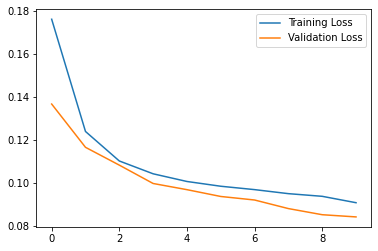

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

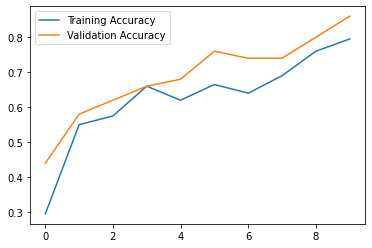

In [12]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

In [13]:
encoded_data = hybrid_autoencoder.encoder(x_train).numpy()
decoded_data = hybrid_autoencoder.decoder(encoded_data).numpy()

(3,)
(3,)


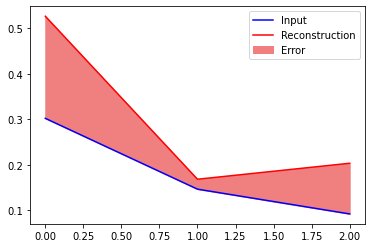

In [14]:
print(np.shape(decoded_data[0]))
print(np.shape(x_train[0]))
input_data = x_train[1]
output_data = decoded_data[1]
plt.plot(input_data, 'b')
plt.plot(output_data, 'r')
plt.fill_between(np.arange(np.shape(output_data)[0]), output_data, input_data, color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()